<a href="https://colab.research.google.com/github/stalin99835/DUDL/blob/main/hor_and_vert_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# numpy
import numpy as np


from sklearn.model_selection import train_test_split

# drawing lines
import skimage.draw as draw

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,TensorDataset,Subset

#plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [44]:
def createHoriz(noTrainImages):

  trainSet = np.zeros((noTrainImages,1,30,30))
  trainLabels = np.zeros((noTrainImages))


  for i in range(noTrainImages):
      image1 = np.random.randint(100, 200, (30, 30), dtype=np.uint8)
      randomTst = np.random.randint(1,3,dtype=np.uint8)
      randomLine = np.random.randint(1, 29,dtype=np.uint8)

      if randomTst > 1.5:
          row1,col1 = draw.line(0, randomLine, 29, randomLine) # vertical line in the middle of the image
          image1[row1,col1] = 1
          trainSet[i,0,:,:] = image1
          trainLabels[i] = 1 # vertical line
      else:
          row1,col1 = draw.line(randomLine,0, randomLine,29) # horizontal line in the middle of the image
          image1[row1,col1] = 1
          trainSet[i,0,:,:] = image1
          trainLabels[i] = 0  # horizontal line
  return trainSet, trainLabels

In [45]:
def createDiag(noTestImages):

  testSet = np.zeros((noTestImages,1,30,30))
  gradient = np.zeros((noTestImages))

  for i in range(noTestImages):
      image1 = np.random.randint(100, 200, (30, 30), dtype=np.uint8)
      randomTst = np.random.randint(1,3,dtype=np.uint8)
      randomLine = np.random.randint(0, 28,dtype=np.uint8)

      if randomTst > 1.5:
          row1,col1 = draw.line(randomLine,0, 29-randomLine, 29)  # diagonal line across
          image1[row1,col1] = 1
          testSet[i,0,:,:] = image1
          # Calculate the gradient
          randomLine = float(randomLine)
          gradient[i] = (randomLine - (29-randomLine)) / 30
      else:
          row1,col1 = draw.line(0,randomLine, 29, 29-randomLine)  # diagonal line vertical
          image1[row1,col1] = 1
          testSet[i,0,:,:] = image1
          # Calculate the gradient, ensuring we don't divide by zero - vertical dsitance is always 30, horizontal distance is randomLine - (29-randomLine)
          randomLine = float(randomLine)
          gradient[i] = (30 / (randomLine - (29-randomLine) ) if (randomLine - (29-randomLine)) != 0 else 0)  # Avoid division by zero
  return testSet, gradient



In [101]:
# createhorizontal lines for training
noTrainImages = 10000
trainSet,trainLabels = createHoriz(noTrainImages)

# show shape
print(f'train set size {trainSet.shape}')
print(f'train labels shape {trainLabels.shape}')

trainLabels = trainLabels.reshape(-1,1)
print(f'train labels shape {trainLabels.shape}')

# print results in pilot when number images is small

if noTrainImages < 11:
  fig, ax = plt.subplots(1,noTrainImages)
  for x in range(noTrainImages):
    ax[x].imshow(trainSet[x,0,:,:], cmap="gray")
    ax[x].set_title(f"L: {trainLabels[x]}",fontsize=8)
    ax[x].axis('off')
  plt.show()

train set size (10000, 1, 30, 30)
train labels shape (10000,)
train labels shape (10000, 1)


test set shape (10, 1, 30, 30)
gradients shape (10,)
gradient shape (10, 1)


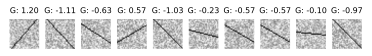

In [111]:
#create diagonal lines for test set
noTestImages = 10

testSet,gradients = createDiag(noTestImages)

print(f'test set shape {testSet.shape}')
print(f'gradients shape {gradients.shape}')

gradient = gradients.reshape(-1,1)
print(f'gradient shape {gradient.shape}')

# print results in pilot when numberimages is small
if noTestImages < 11:
  fig, ax = plt.subplots(1,noTestImages)
  for x in range(noTestImages):
      ax[x].imshow(testSet[x,0,:,:], cmap="gray")
      ax[x].set_title(f"G: {gradients[x]:.2f}", fontsize=8)
      ax[x].axis('off')
  plt.show()
  plt.show()

In [86]:
# use scikitlearn to split the data
#train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=50)

# Convert numpy arrays to PyTorch tensors and ensure correct data types
trainSet_t = torch.from_numpy(trainSet).float()
trainLabels_t = torch.from_numpy(trainLabels).float()
testSet_t = torch.from_numpy(testSet).float()
gradient_t = torch.from_numpy(gradient).float()

# then convert them into PyTorch Datasets
train_data = TensorDataset(trainSet_t, trainLabels_t)
test_data  = TensorDataset(testSet_t, gradient_t)

# finally, translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data))

In [104]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,16,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(16) # input the number of channels in this layer
      # output size: (30+2*1-3)/1 + 1 = 30/2 = 15 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(16,32,3,padding=0)
      self.bnorm2 = nn.BatchNorm2d(32) # input the number of channels in this layer
      # output size: (15+2*0-3)/1 + 1 = 13/2 = 6 (/2 b/c maxpool)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(6*6*32,64)
      self.fc2 = nn.Linear(64,10)
      self.fc3 = nn.Linear(10,1)
      self.fc4 = nn.Sigmoid()

      ##----------------parameters---------------###
      self.dropoutPerc = 0.3

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=self.dropoutPerc,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=self.dropoutPerc,training=self.training) # training=self.training means to turn off during eval mode
      x = self.fc3(x)
      #x = F.dropout(x,p=.5,training=self.training) # training=self.training means to turn off during eval mode
      x = self.fc4(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(printtoggle)

  # loss function
  #lossfun = nn.CrossEntropyLoss()
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [67]:
# a function that trains the model

def function2trainTheModel(epochs):

  # number of epochs
  numepochs = epochs

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  ##net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      ##X = X.to(device)
      ##y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      #print(f'yHat shape {yHat.shape}')
      #print(f'y shape {y.shape}')

      # Reshape y to match yHat's shape [batch_size, 1]
      #loss = lossfun(yHat,y.unsqueeze(1))
      loss = lossfun(yHat,y.float())

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      matches = ((yHat>.5).squeeze() == y.squeeze())
      matchesNumeric = matches.float()
      accuracyPct = torch.mean(matchesNumeric)
      #batchAcc.append(torch.mean(predictions==y.unsqueeze(1)).float()).item()
      batchAcc.append(accuracyPct.item())
      #trainAcc[epochi] = 100*torch.mean((predictions==y).float())

      #batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    #### test performance
    ##net.eval() # switch to test mode
    ##X,y = next(iter(test_loader))

    # push data to GPU
    ##X = X.to(device)
    ##y = y.to(device)

    # forward pass and loss
    ##with torch.no_grad():
      ##yHat = net(X)
      ##loss = lossfun(yHat,y)

    # and get average losses and accuracies across the batches
    ##devLoss[epochi] = loss.item()
    ##devAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

  # end epochs

  # function output
  return trainLoss,trainAcc,net

In [112]:
epochs = 30
trainLoss, trainAcc,net = function2trainTheModel(epochs)

In [84]:
print(trainLoss)
print(trainAcc)

tensor([0.7140, 0.7208, 0.6985, 0.6912, 0.6717, 0.6883, 0.6654, 0.6228, 0.6516,
        0.6207, 0.6261, 0.6186, 0.5936, 0.6237, 0.6126, 0.6061, 0.5860, 0.6287,
        0.5869, 0.6114, 0.5947, 0.5541, 0.6068, 0.5475, 0.5584, 0.5417, 0.5391,
        0.5773, 0.5494, 0.5232])
tensor([50.0000, 70.0000, 70.0000, 80.0000, 60.0000, 70.0000, 70.0000, 90.0000,
        80.0000, 70.0000, 90.0000, 80.0000, 90.0000, 80.0000, 80.0000, 80.0000,
        80.0000, 70.0000, 80.0000, 70.0000, 60.0000, 80.0000, 60.0000, 90.0000,
        90.0000, 90.0000, 90.0000, 80.0000, 80.0000, 90.0000])


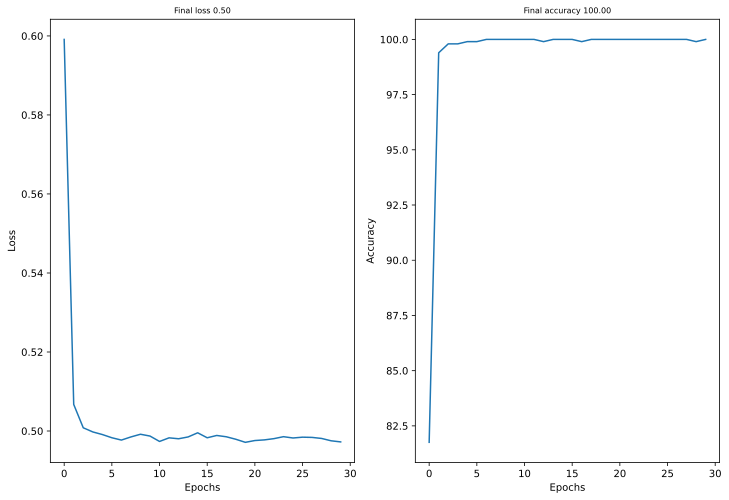

In [113]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
ax[0].plot(range(epochs), trainLoss) # Changed epochs to range(epochs)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title(f'Final loss {trainLoss[-1]:.2f}',fontsize=8)
ax[1].plot(range(epochs), trainAcc) # Changed trainAcc.epochs to range(epochs), trainAcc
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Final accuracy {trainAcc[-1]:.2f}',fontsize=8)
plt.show()

In [ ]:
## test against diagonal lines